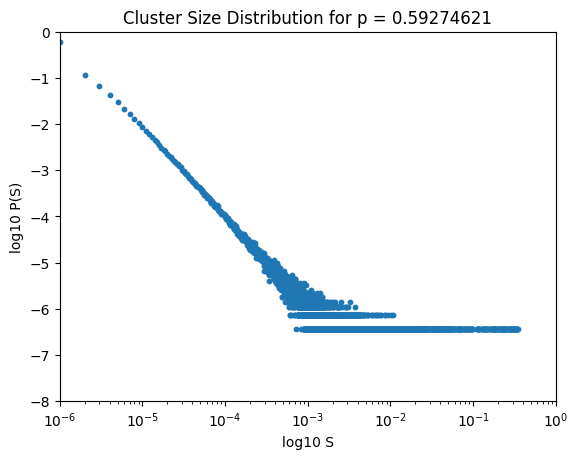

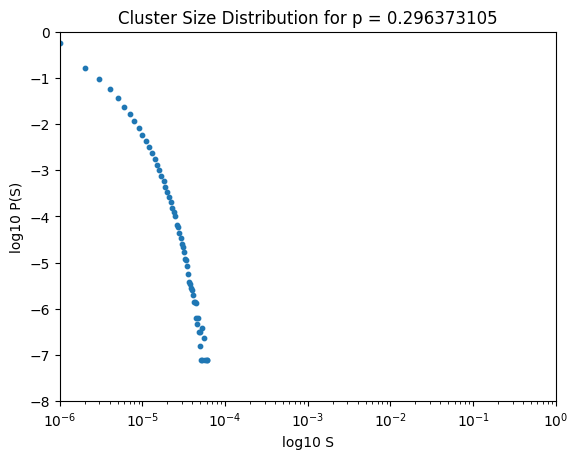

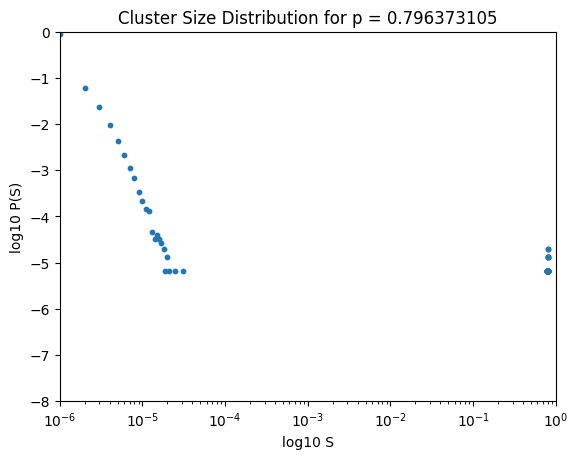

In [1]:
"""Percolation functions.

Notes:
- create `images/` (or change file paths below)
- cd to the directory containing this file and run `python3 percolation.py`
OR import and run in .ipynb
- add/change functions in line 96 to run what you want when calling the script
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage

##############################################
# adapted for POCs 1

L_VALUES = [20, 50, 100, 200, 500, 1000]  # square lattice of size L
# Pc for square lattices is a known/accepted quantity obtained from simulations
# Visually, we can see it is approx 0.59, and wikipedia says it is 0.59274621
# https://en.wikipedia.org/wiki/Percolation_theory
PERC_CRIT_PROB = 0.59274621  # p_c


def percolation_model(prob, L):
    """Run site percolation, return world as 2D array (the 'world')."""
    return np.random.choice([0, 1], size=(L, L), p=[1-prob, prob])


def get_perc_largest_cluster(prob, L, N_sim=0):
    if N_sim > 0:
        all_cluster_sizes = []

    # Run multiple simulations to get average cluster sizes
        for _ in range(N_sim):
            world = percolation_model(prob, L)
            structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
            label_world, nb_labels = ndimage.label(world, structure)
            cluster_sizes = ndimage.sum(world, label_world, range(nb_labels + 1))
            all_cluster_sizes.extend(cluster_sizes)

        return np.max(all_cluster_sizes), all_cluster_sizes
    """Get the largest cluster in a percolation model."""
    world = percolation_model(prob, L)  # run model

    # filter largest cluster
    # Site percolation
    structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]  # define connection
    # label_world is array of same shape as world, with each elem (cluster) labeled
    # nb_labels is the number of labels/clusters
    label_world, nb_labels = ndimage.label(world, structure)
    # ndimage.sum sums values in world for each label in label_world
    # range(nb_labels + 1) says labels to sum over
    # cluster_sizes is array of elems, each is sum of values in world for that label
    cluster_sizes = ndimage.sum(world, label_world, range(nb_labels + 1))
    return cluster_sizes.max(), cluster_sizes


# Parameters
def percolation_simulation():
    """Run entire percolation simulation."""
    probabilities = np.linspace(0, 1, 100)  # occupation probs (increments of 10^-2)

    # For each L, run N_tests for occupation prob
    for L in L_VALUES:
        print(f"L = {L}")
        prob_to_max_avg_cluster = []
        for p in probabilities:
            # run N_tests=100 of the percolation model
            # (a loop would be equivalent, but we're optimizing below
            max_cluster_sizes = [get_perc_largest_cluster(p, L)[0] for _ in range(100)]
            max_avg_cluster_size = np.mean(max_cluster_sizes)
            # fractional size: normalize the avg size by the total number of cells (L)
            prob_to_max_avg_cluster.append(max_avg_cluster_size / (L * L))
        plt.plot(probabilities, prob_to_max_avg_cluster, label=f"L = {L}")

    plt.axvline(PERC_CRIT_PROB, color="black", linestyle="--",
                label="Critical probability")
    plt.legend()
    plt.xlabel("Occupation probability")
    plt.ylabel("Fractional size of largest cluster")
    plt.savefig("images/h8_perc_sim_avg_vs_prob")
    print("Simulation complete and plot saved.")


def cluster_dist_plot(L=1000):
    dict_p_c_vals = {
        PERC_CRIT_PROB: 0,  # at critical probability
        PERC_CRIT_PROB / 2: 1,  # below critical
        PERC_CRIT_PROB + (1 - PERC_CRIT_PROB) / 2: 2  # above critical
    }
    total_sites = L * L  # Total number of sites in the lattice

    for p_c, label in dict_p_c_vals.items():
        _, all_cluster_sizes = get_perc_largest_cluster(p_c, L, N_sim=100)  # average over 100 simulations
        df = pd.DataFrame(all_cluster_sizes, columns=["clust_size"])
        dist = df['clust_size'].value_counts().sort_index()
        dist = dist.rename_axis('clust_size').reset_index(name='frequency')

        # Normalize the cluster sizes by total lattice area
        dist["clust_size"] = dist["clust_size"] / total_sites

        # Normalize the frequency by the total number of clusters
        total_clusters = dist["frequency"].sum()
        dist["log_frequency"] = dist["frequency"] / total_clusters  # Fraction of clusters
        dist["log_frequency"] = np.log10(dist["log_frequency"]) 

        plt.clf()
        plt.scatter(dist["clust_size"], dist["log_frequency"], marker="o", s=10)

        plt.xscale("log")

        plt.xlim([10**-6, 1]) 

        plt.ylim([-8, 0])

        plt.xlabel("log10 S")
        plt.ylabel("log10 P(S)")
        plt.title(f"Cluster Size Distribution for p = {p_c}")

        # plt.savefig(f"images/cluster_size_dist_{label}_{L}.png")
        plt.show()

# 3
# percolation_simulation()
# 4
cluster_dist_plot()


##############################################
# MOCS - stochastic cellular automata example (runable as is)

# def run_random_walker(world, position, history, steps):
#     """Run a random walker on a 2D world.
#
#       Note this does wrapping in the array--periodic boundary.
#     """
#     N1 = world.shape[0]
#     N2 = world.shape[1]
#     (i, j) = position
#     for k in range(steps):  # for every step
#         world[position] = 0.67
#         (i, j) = position
#         die = random.uniform(0, 1)
#         if die < 0.25:  # right step
#             position = (i, (j + 1) % N2)
#         elif die < 0.5:  # bottom step
#             position = ((i - 1) % N1, j)
#         elif die < 0.75:  # left step
#             position = (i, (j - 1) % N2)
#         else:  # top step
#             position = ((i + 1) % N1, j)
#         world[position] = 1
#         history.append(position)

#     return (world, position, history)


# def run_percolation(world, probability):
#     """Run stochastic site percolation on a 2D world."""
#     N1 = world.shape[0]
#     N2 = world.shape[1]
#     for i in range(N1):  # for cell in every row
#         for j in range(N2):  # and every column
#             die = random.uniform(0, 1)
#             if die < probability:
#                 world[(i, j)] = 1
#             else:
#                 world[(i, j)] = 0

#     return world


# Parameters
# N1, N2 = 512, 512  # height, width
# # occupation probability
# probability = 0.6  # @param {type:"slider", min:0, max:1, step:0.01}
# # initial conditions of zero
# world = np.zeros((N1, N2))

# world = run_percolation(world, probability)  # run model

# # Set up the figure
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# ax1.set_ylim(0, N1)
# ax1.set_xlim(0, N2)
# ax2.set_ylim(0, N1)
# ax2.set_xlim(0, N2)
# ax1.set_aspect("equal")
# ax2.set_aspect("equal")

# # filter largest cluster
# structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]  # define connection
# label_world, nb_labels = ndimage.label(world, structure)  # label clusters
# sizes = ndimage.sum(world, label_world, range(nb_labels + 1))
# mask = sizes >= sizes.max()
# binary_img = mask[label_world]

# # Plot the world
# ax1.imshow((world), cmap=plt.get_cmap(cm.bone), origin="lower")
# ax2.imshow(binary_img, cmap=plt.get_cmap(cm.bone), origin="lower")

# # Add label
# ax1.text(2, N1 + 5, f"Site percolation with probability {probability}",
#         fontsize=18)
# ax2.text(2, N1 + 5, f"Largest cluster found", fontsize=18)
# plt.show()

In [147]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import label

# # Initialize spark distribution
# def initialize_spark_distribution(L):
#     ell = L / 10
#     spark_distribution = np.zeros((L, L))
#     for i in range(L):
#         for j in range(L):
#             spark_distribution[i, j] = np.exp(-i / ell) * np.exp(-j / ell)
#     spark_distribution /= np.sum(spark_distribution)
#     return spark_distribution

# # Initialize empty forest
# def initialize_forest(L):
#     return np.zeros((L, L), dtype=int)

# # Calculate fire yield based on spark distribution
# def calculate_forest_yield(forest, spark_distribution):
#     labeled_forest, num_clusters = ndimage.label(forest)
#     cluster_sizes = ndimage.sum(forest, labeled_forest, range(1, num_clusters + 1))
#     component_size_map = np.zeros_like(forest)
#     for i in range(1, num_clusters + 1):
#         component_size_map[labeled_forest == i] = cluster_sizes[i - 1]
#     # Compute normalized yield
#     yield_result = np.sum(spark_distribution * component_size_map)
#     return yield_result

# def calculate_fire_yield(forest, spark_distribution):
#     structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
#     labeled_forest, num_clusters = label(forest, structure=structure)
#     cluster_sizes = np.bincount(labeled_forest.ravel())[1:]
#     component_size_map = np.zeros_like(forest)
#     for cluster_id in range(1, num_clusters + 1):
#         component_size_map[labeled_forest == cluster_id] = cluster_sizes[cluster_id - 1]
#     expected_yield = np.sum(spark_distribution * component_size_map)
#     return expected_yield

# # Place tree based on best yield for each D
# def place_tree(forest, spark_distribution, D, placement_sequence):
#     L = forest.shape[0]
#     best_yield = -np.inf
#     best_position = None
#     for _ in range(D):
#         i, j = np.random.randint(0, L, size=2)
#         if forest[i, j] == 0:
#             forest[i, j] = 1
#             yield_if_planted = calculate_fire_yield(forest, spark_distribution)
#             forest[i, j] = 0  # Reset tree after evaluation
#             if yield_if_planted > best_yield:
#                 best_yield = yield_if_planted
#                 best_position = (i, j)
#     if best_position:
#         forest[best_position] = 1
#         placement_sequence.append(best_position)  # Record the optimal placement
#     return best_yield

# # Simulate forest growth and capture forest configuration at peak yield
# def simulate_forest_growth(L, spark_distribution, D, max_trees):
#     forest = initialize_forest(L)
#     yields = []
#     densities = []
#     placement_sequence = []  # Track sequence of tree placements
    
#     peak_yield = -np.inf
#     peak_density = 0
#     peak_index = 0
#     peak_forest = None  # Initialize peak_forest to capture forest at peak yield
    
#     for t in range(max_trees):
#         # Place the tree and get yield
#         current_yield = place_tree(forest, spark_distribution, D, placement_sequence)
#         current_density = (t + 1) / max_trees  # Calculate density
        
#         # Track yields and densities
#         yields.append(current_yield)
#         densities.append(current_density)
        
#         # Identify peak yield and corresponding density
#         if current_yield > peak_yield:
#             peak_yield = current_yield
#             peak_density = current_density
#             peak_index = t
#             peak_forest = forest.copy()  # Capture the forest configuration at peak yield
    
#     return yields, densities, peak_yield, peak_density, peak_index, peak_forest, placement_sequence

# # Analyze cluster sizes at peak yield
# def analyze_cluster_sizes(forest):
#     """Calculate component sizes and return them sorted."""
#     structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
#     labeled_forest, num_clusters = label(forest, structure=structure)
#     cluster_sizes = np.bincount(labeled_forest.ravel())[1:]  # Skip background (label 0)
#     cluster_sizes = cluster_sizes[cluster_sizes > 0]  # Filter out zero-sized clusters
#     return np.sort(cluster_sizes)[::-1]  # Sort in descending order for Zipf plot

# def rebuild_forest_from_sequence(L, placement_sequence, stop_at):
#     """Rebuilds the forest configuration up to a specified point in the sequence."""
#     forest = initialize_forest(L)
#     for idx, position in enumerate(placement_sequence):
#         if idx >= stop_at:
#             break
#         forest[position] = 1
#     return forest

# # Parameters
# L = 64
# D_values = [1, 2, 3, L]
# max_trees = L * L
# spark_distribution = initialize_spark_distribution(L)

# #a
# # Run simulation and capture peak yield forest for each D
# fig, axes = plt.subplots(1, len(D_values), figsize=(15, 5))
# for idx, D in enumerate(D_values):
#     if D > max_trees:  # Skip D if it exceeds the number of possible placements
#         continue
#     yields ,_, _, _, _, peak_forest, _ = simulate_forest_growth(L, spark_distribution, D, max_trees)
#     axes[idx].imshow(peak_forest, cmap='Greens', origin="upper")
#     axes[idx].set_title(f"D = {D} at Peak Yield")
#     axes[idx].axis("off")

# # a
# plt.suptitle("Forest at Peak Yield for Different Values of D")
# plt.show()

# #b
# fig, ax = plt.subplots(figsize=(10, 6))

# for D in D_values:
#     yields, densities, peak_yield, peak_density, peak_index, _, _ = simulate_forest_growth(L, spark_distribution, D, max_trees)
#     ax.plot(range(len(yields)), yields, label=f"D = {D}")
#     ax.plot(peak_index, peak_yield, 'o', markersize=8, label=f"Peak for D={D} (Yield={peak_yield:.2f})")

#     print(f"For D = {D}: Peak Yield = {peak_yield:.4f}")

# # Configure plot
# ax.set_xlabel("ith Tree Added")
# ax.set_ylabel("Total Tree Yield")
# ax.set_title("Yield Curves for Different Values of D")
# ax.legend()
# plt.show()

# # Run simulation and plot Zipf distributions
# for D in D_values:
#     # Run simulation to get peak yield and placement sequence
#     yields, densities, peak_yield, peak_density, peak_index, _, placement_sequence = simulate_forest_growth(L, spark_distribution, D, max_trees)
    
#     # Rebuild forest up to peak yield using recorded sequence
#     peak_forest = rebuild_forest_from_sequence(L, placement_sequence, peak_index + 1)
    
#     # Debug: Check tree density at peak
#     # print(f"D = {D}: Total trees added at peak = {np.count_nonzero(peak_forest)}")
    
#     # Label clusters and calculate sizes
#     labeled_world, nb_labels = label(peak_forest)  # Default structure for 4-connected neighbors
    
#     # Debug: Check unique labels in labeled_world to confirm clusters
#     unique_labels, label_counts = np.unique(labeled_world, return_counts=True)
#     # print(f"Unique labels in labeled_world for D = {D}: {unique_labels}")
#     # print(f"Label counts (including background) for D = {D}: {label_counts}")
    
#     # Remove background label (0), if any
#     cluster_sizes = label_counts[1:]
    
#     # Check if there are any clusters left after removing the background
#     if len(cluster_sizes) == 0:
#         print(f"No clusters found for D = {D}")
#         continue
    
#     # Sort cluster sizes in descending order for Zipf plot
#     sorted_cluster_sizes = sorted(cluster_sizes, reverse=True)
#     print(f"Sorted cluster sizes for D = {D}: {sorted_cluster_sizes[:10]}")  # Check sorted sizes
    
#     # Check if sorted_cluster_sizes is empty after sorting
#     if len(sorted_cluster_sizes) == 0:
#         print(f"Empty sorted_cluster_sizes for D = {D}, skipping plot.")
#         continue
    
#     # Plot Zipf distribution
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ranks = np.arange(1, len(sorted_cluster_sizes) + 1)  # Rank from 1 to number of clusters
#     ax.scatter(np.log10(ranks), np.log10(sorted_cluster_sizes), s=10, color='blue')  # Log-log plot

#     # Configure plot
#     ax.set_xlabel('Log10(Rank)')
#     ax.set_ylabel('Log10(Cluster Size S)')
#     ax.set_title(f"Zipf Distribution of Tree Component Sizes at Peak Yield (D = {D})")
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for readability
#     plt.show()
#     print(f"Finished plotting Zipf distribution for D = {D}")


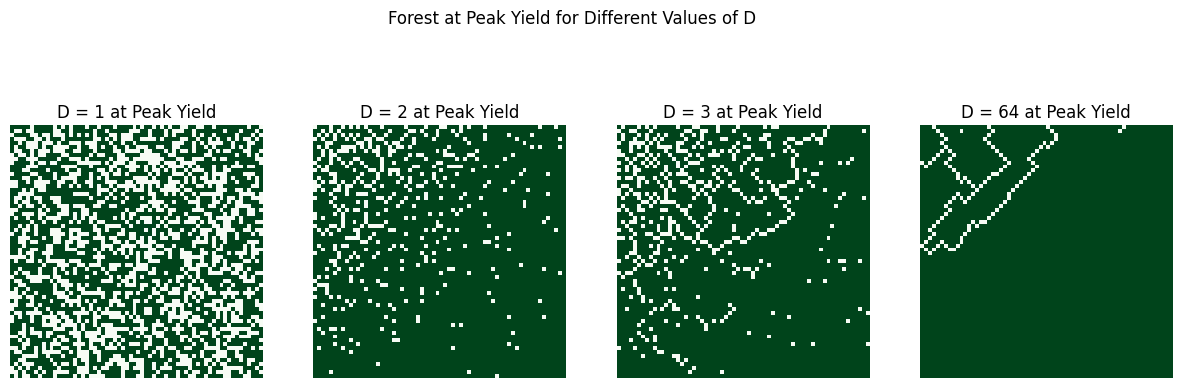

In [157]:
"""Functions to run the HOT model.

Notes
- fire spreads to nearest neighbor only
- connected clusters burn completely
- empty cells are not ignited


D = 1  # 2, L, L^2 ... this is D randomly chosen placements of the next tree against the spark distrib
    D=2... select 2 trees and choose the one with lower cost

"""
import random

import numpy as np
from scipy import ndimage


def spark_distrib(L):
    """Generate spark distribution."""
    world = np.zeros((L, L))  # create world of no trees
    for i in range(L):
        for j in range(L):
            l_norm = L/10
            spark_prob = np.exp(-i/l_norm) * np.exp(-j/l_norm)  # probability of spark at (i,j)
            world[i, j] = spark_prob
    return world / np.sum(world)  # normalize


def label_by_cluster_size(forest: np.ndarray) -> np.ndarray:
    """Labels a 2d array by connected cluster size"""
    labeled_world, nb_labels = ndimage.label(forest)
    cluster_sizes = ndimage.sum(forest, labeled_world, range(1, nb_labels + 1))
    output = np.zeros_like(labeled_world)
    for label_value in range(1, nb_labels + 1):
        output[labeled_world == label_value] = cluster_sizes[label_value - 1]
    # returns forest size array where each cell is its cluster size
    return output


def yield_size(L, forest: np.ndarray, spark_distrib: np.ndarray, normalize=True):
    """Measures average area of forest left as trees after fire.
    f(c) = distrib of fire sizes, c (=cost). This is a distrib of the number of cells burned in each cluster (so a distrib of cluster sizes).
    density = sites containing trees
    Yield = (density - c) / num_cells ... dividing to normalize

    Return yield size
    """
    costs = np.zeros((forest.shape[0], forest.shape[0]))  # initialize costs
    # Compute the size of each cluster
    cluster_sizes = label_by_cluster_size(forest)
    costs = spark_distrib * cluster_sizes
    density = np.sum(forest)  # total number of trees
    # want to use this to record forest_yield
    if normalize:
        return (density - np.sum(costs))/(L*L), density/(L*L)
    return density - np.sum(costs), density

def hot_model(L, D):
    """Run the HOT model."""
    # Initialize forest
    forest = np.zeros((L, L))  # create world of no trees
    spark_dist = spark_distrib(L)  # create spark distribution

    forest_results = []  # to store results for each test tree
    yield_results = []  # to store yield results
    density_results = []  # to store density results

    for _ in range(L*L):
        test_tree_locs = []  # to store locations of chosen test trees
        test_yield_results = []
        # for each TEST tree, test D ways of adding a tree
        for _ in range(D):
            forest_copy = forest.copy()
            # randomly place 'test' D trees from forest where there are no trees
            test_tree = random.choice(np.argwhere(forest == 0))
            test_tree_locs.append(test_tree)
            # add test tree to forest
            forest_copy[test_tree[0], test_tree[1]] = 1
            # recalculate cluster sizes and yield
            yields, _ = yield_size(L, forest_copy, spark_dist)
            test_yield_results.append(yields)

        # out of TEST trees, selec the index of the tree with highest avg yield make that coord a tree
        best_tree = np.argmax(test_yield_results).astype(int)
        best_tree_coords = test_tree_locs[best_tree]
        # set location of best_tree to 1
        forest[best_tree_coords[0], best_tree_coords[1]] = 1

        # re-measure yield as a function of trees added
        actual_yield, actual_density = yield_size(L, forest, spark_dist, False)
        yield_results.append(actual_yield)
        density_results.append(actual_density)

        # store tree cluster results each time forest changes
        forest_results.append(forest.copy())

    # get forest_results at peak yield
    peak_yield = np.argmax(yield_results)
    peak_forest = forest_results[peak_yield].astype(int)  # Ensure integer type for np.bincount
    cluster_sizes = np.bincount(peak_forest.ravel()) 

    return yield_results, density_results, peak_forest, cluster_sizes

L = 64
D_values = [1, 2, 3, L]

# # Run simulation and capture peak yield forest for each D
fig, axes = plt.subplots(1, len(D_values), figsize=(15, 5))
for idx, D in enumerate(D_values):
    yield_results, density_results, peak_forest, _ = hot_model(L, D)
    axes[idx].imshow(peak_forest, cmap='Greens', origin="upper")
    axes[idx].set_title(f"D = {D} at Peak Yield")
    axes[idx].axis("off")

# a
plt.suptitle("Forest at Peak Yield for Different Values of D")
plt.show()


Running HOT model with L=64 and D=1
Yield range for D=1: min=0.0, max=2367.998124486143


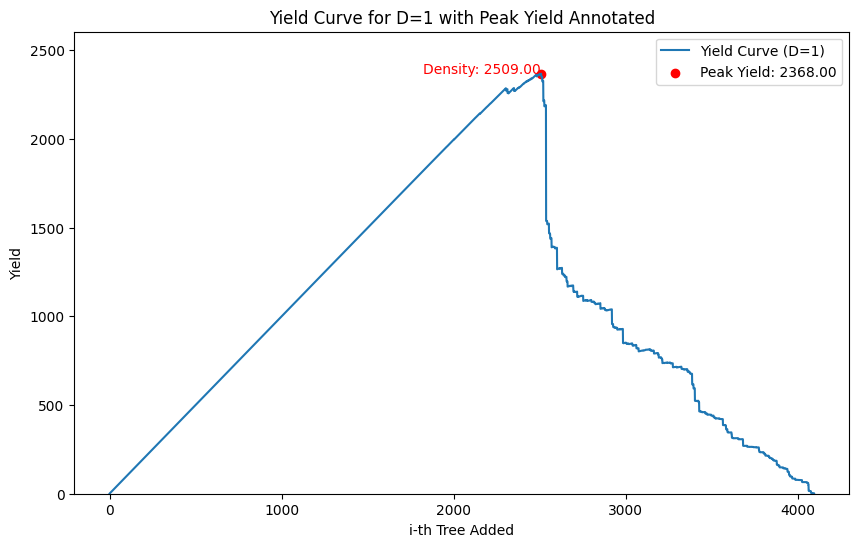

Running HOT model with L=64 and D=2
Yield range for D=2: min=0.0, max=3396.9245655306177


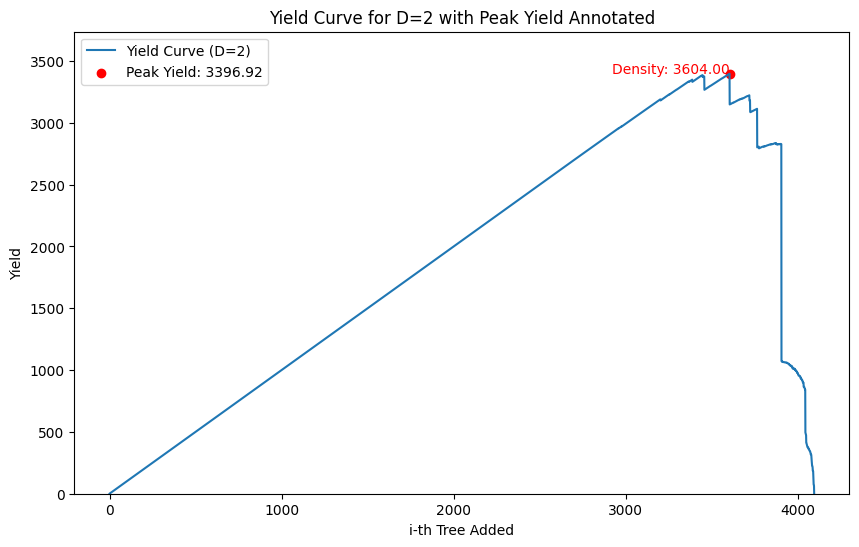

Running HOT model with L=64 and D=3
Yield range for D=3: min=0.0, max=3689.2104365244377


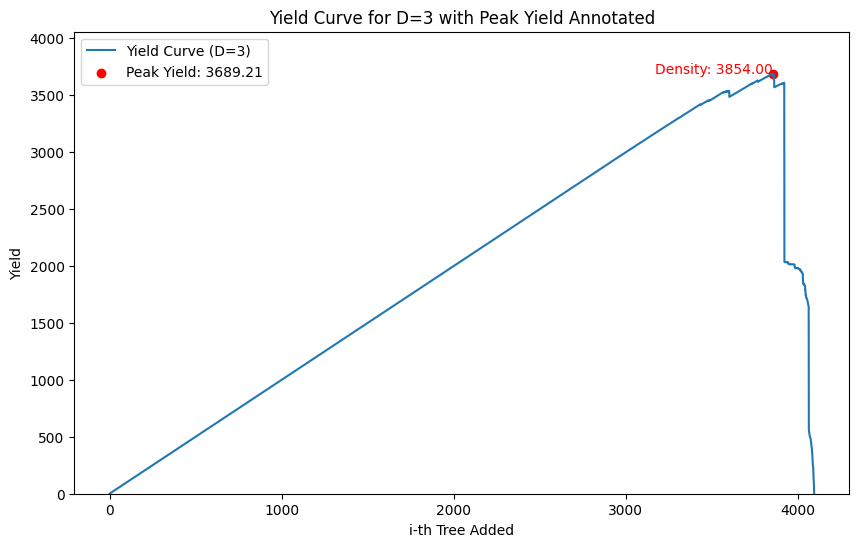

Running HOT model with L=64 and D=64
Yield range for D=64: min=0.0, max=3817.8019455351086


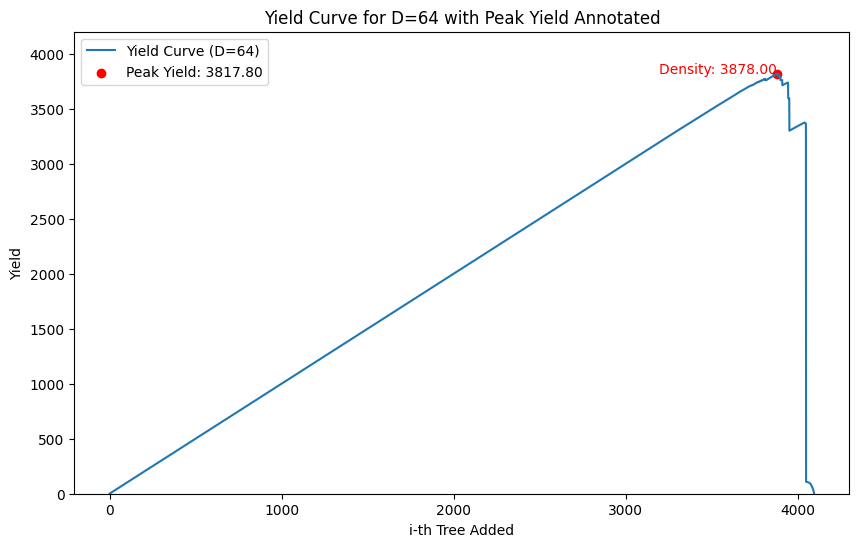

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 64
D_values = [1, 2, 3, L]

# Run simulations and plot yield curves
for D in D_values:
    print(f"Running HOT model with L={L} and D={D}")
    yield_results, density_results, _, _ = hot_model(L, D)

    # Debug: Check the range of yield_results
    print(f"Yield range for D={D}: min={min(yield_results)}, max={max(yield_results)}")

    # Identify the peak yield and corresponding density
    peak_yield_idx = np.argmax(yield_results)
    peak_yield = yield_results[peak_yield_idx]
    peak_density = density_results[peak_yield_idx]

    # Plot the yield curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(yield_results)), yield_results, label=f"Yield Curve (D={D})")
    plt.scatter(peak_yield_idx, peak_yield, color='red', label=f"Peak Yield: {peak_yield:.2f}")
    plt.text(peak_yield_idx, peak_yield, f"Density: {peak_density:.2f}", color='red', ha='right')

    # Adjust y-axis limit dynamically based on actual yield values
    plt.ylim(0, max(yield_results) * 1.1)
    plt.xlabel("i-th Tree Added")
    plt.ylabel("Yield")
    plt.title(f"Yield Curve for D={D} with Peak Yield Annotated")
    plt.legend()
    plt.show()


Running HOT model with L=64 and D=1


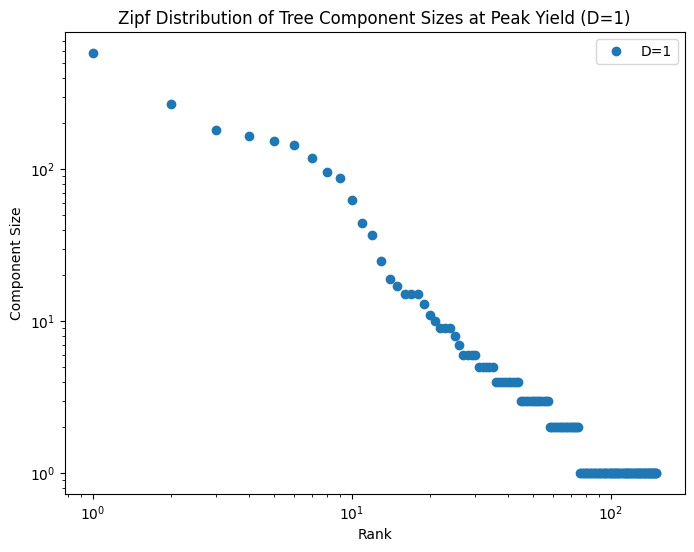

Running HOT model with L=64 and D=2


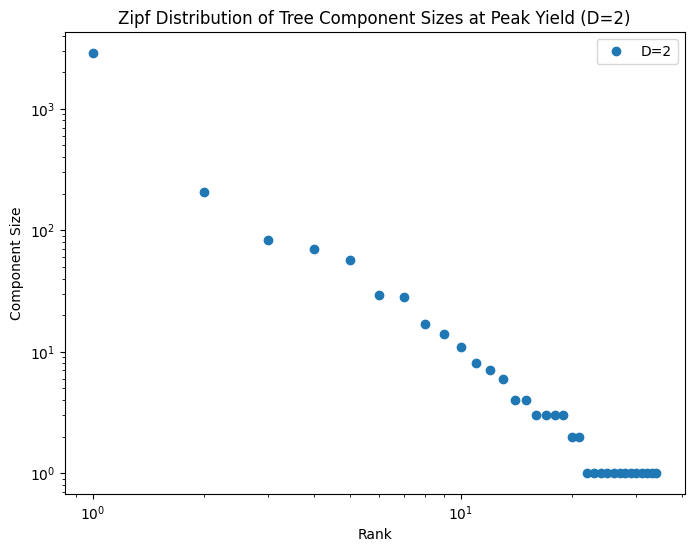

Running HOT model with L=64 and D=3


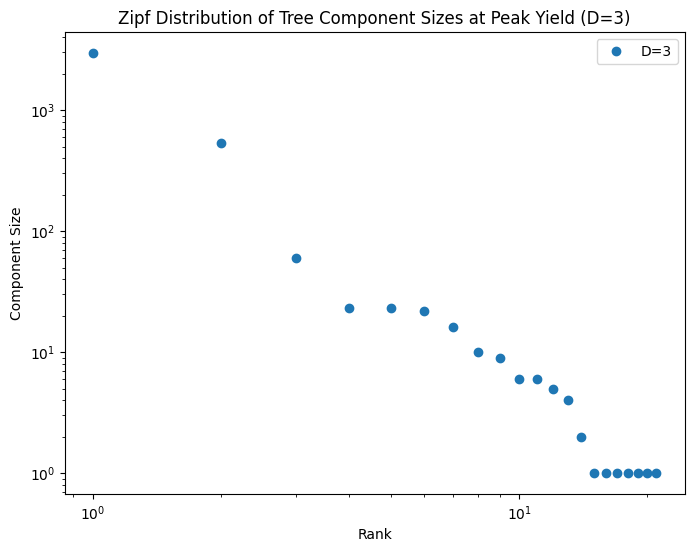

Running HOT model with L=64 and D=64


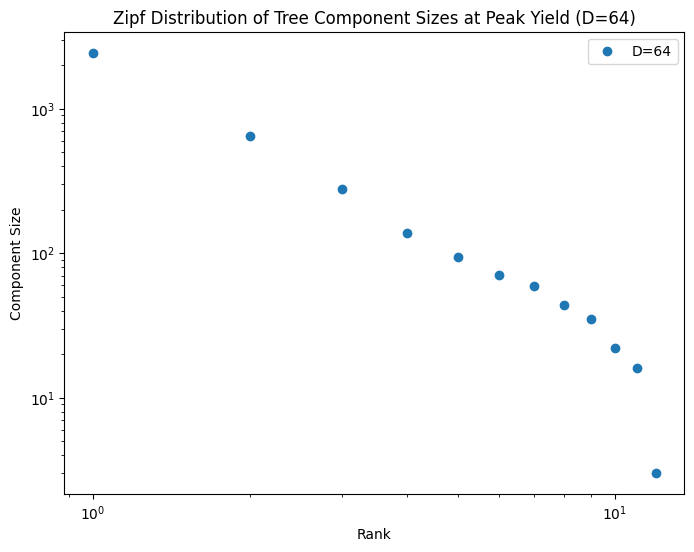

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Function to calculate component sizes for Zipf plot
def calculate_component_sizes(forest):
    labeled_forest, num_features = ndimage.label(forest)
    component_sizes = ndimage.sum(forest, labeled_forest, range(1, num_features + 1))
    return np.sort(component_sizes)[::-1]  # Sort in descending order for Zipf plot

# Parameters
L = 64
D_values = [1, 2, 3, L]

# Run simulations and plot the forest at peak yield for each D
for D in D_values:
    print(f"Running HOT model with L={L} and D={D}")
    yield_results, density_results, peak_forest, _ = hot_model(L, D)

    # Ensure peak_forest is integer for visualization
    peak_forest = peak_forest.astype(int)

    # Calculate component sizes for Zipf plot
    component_sizes = calculate_component_sizes(peak_forest)

    # Plot Zipf (size) distribution on a log-log scale
    plt.figure(figsize=(8, 6))
    plt.loglog(range(1, len(component_sizes) + 1), component_sizes, marker="o", linestyle="none", label=f"D={D}")
    plt.xlabel("Rank")
    plt.ylabel("Component Size")
    plt.title(f"Zipf Distribution of Tree Component Sizes at Peak Yield (D={D})")
    plt.legend()
    plt.show()
